The imaging light ray incident on the retina plane at the point $x_r$ and on the pupil plane at the point $x_p$ corresponds to an incoming light ray that intersects the sampling plane located at a distance of $z_s$ at the point $x_s$.

For a given focus distance $z_f$, $x_s$ can be defined by a linear transformation of $x_r$ and $x_p$:
$$ \begin{align*}
    x_s = z_s x_r + \Big( 1 - \frac{z_s}{z_f} \Big) x_p && (1)\\
\end{align*} $$

The retina images formed for all focus distances can be derived from the light field $L(x_p, y_p, x_s, y_s)$ by using (1):
$$ \begin{align*}
    R(x_r, y_r, z_f) = \iint_{-\infty}^{\infty} L\!\left( x_p, y_p, z_s x_r + \Big( 1 - \frac{z_s}{z_f} \Big) x_p, z_s y_r + \Big( 1 - \frac{z_s}{z_f} \Big) y_p \right) \,
                                                O(x_r, y_r, x_p, y_p) \, \mathrm{d}x_p \, \mathrm{d}y_p && (2)\\
\end{align*} $$

Where $O(x_r, y_r, x_p, y_p)$ is responsible for the finite pupil aperture and angle-dependent effects such as vignetting.

The light field $\tilde{L}(x_p, y_p, x_s, y_s)$ that is emitted by the display can be defined as:
$$ \begin{align*}
    \tilde{L}(x_p, y_p, x_s, y_s) = \sum_{i = 1}^{n} c_{i} \, G_i(x_p, y_p, x_s, y_s) && (3)\\
\end{align*} $$

Where each display element $i$ emits a constant light field $G_i(x_p, y_p, x_s, y_s)$ that is attenuated by a coefficient $c_i \in [0, 1]$.

The resulting retina images formed for all focus distances from observing such display can be defined as:
$$ \begin{align*}
    \tilde{R}(x_r, y_r, z_f) &= \iint_{-\infty}^{\infty} \tilde{L}\!\left( x_p, y_p, z_s x_r + \Big( 1 - \frac{z_s}{z_f} \Big) x_p, z_s y_r + \Big( 1 - \frac{z_s}{z_f} \Big) y_p \right) \,
                                                         O(x_r, y_r, x_p, y_p) \, \mathrm{d}x_p \, \mathrm{d}y_p && \therefore\\
    \tilde{R}(x_r, y_r, z_f) &= \iint_{-\infty}^{\infty} \left( \sum_{i = 1}^{n} c_{i} \, G_i\!\left( x_p, y_p, z_s x_r + \Big( 1 - \frac{z_s}{z_f} \Big) x_p, z_s y_r + \Big( 1 - \frac{z_s}{z_f} \Big) y_p \right) \right) \,
                                                         O(x_r, y_r, x_p, y_p) \, \mathrm{d}x_p \, \mathrm{d}y_p && \therefore\\
    \tilde{R}(x_r, y_r, z_f) &= \sum_{i = 1}^{n} c_{i} \, \iint_{-\infty}^{\infty} G_i\!\left( x_p, y_p, z_s x_r + \Big( 1 - \frac{z_s}{z_f} \Big) x_p, z_s y_r + \Big( 1 - \frac{z_s}{z_f} \Big) y_p \right) \,
                                                                                   O(x_r, y_r, x_p, y_p) \, \mathrm{d}x_p \, \mathrm{d}y_p && \therefore\\
    \tilde{R}(x_r, y_r, z_f) &= \sum_{i = 1}^{n} c_{i} \, \varphi_i(x_r, y_r, z_f) = \Phi\boldsymbol{c} && (4)\\
\end{align*} $$

Where:
$$ \begin{align*}
    \varphi_i(x_r, y_r, z_f) &= \iint_{-\infty}^{\infty} G_i\!\left( x_p, y_p, z_s x_r + \Big( 1 - \frac{z_s}{z_f} \Big) x_p, z_s y_r + \Big( 1 - \frac{z_s}{z_f} \Big) y_p \right) \,
                                                         O(x_r, y_r, x_p, y_p) \, \mathrm{d}x_p \, \mathrm{d}y_p && (5)\\
\end{align*} $$

For a given desired retina image $R(x_r, y_r, z_f)$, we can formulate the following optimization problem:
$$ \begin{align*}
    & \underset{\boldsymbol{c}}{\text{minimize}} && \big\lVert R - \Phi \boldsymbol{c} \big\rVert_2 && (6)\\
    & \text{subject to} && 0 \leq c_i \leq 1, \quad i = 1, \ldots, n
\end{align*} $$

To solve (6) we employ an iterative multiplicative rule:
$$ \begin{align*}
    \boldsymbol{c} \leftarrow \boldsymbol{c} \, \circ \, \frac{\Phi^\intercal R}{\Phi^\intercal \Phi \boldsymbol{c}} && (7)\\
\end{align*} $$

Where:
$$ \begin{align*}
    \left[ \Phi^\intercal R \right]_{i} = \langle \varphi_{i}, R \rangle &=
    \iiint_{-\infty}^{\infty} \varphi_i(x_r, y_r, z_f) \, R(x_r, y_r, z_f) \, \mathrm{d}x_r \, \mathrm{d}y_r \, \mathrm{d}z_f && (8)\\
    \left[ \Phi^\intercal \Phi \right]_{i, j} = \langle \varphi_{i}, \varphi_{j} \rangle &=
    \iiint_{-\infty}^{\infty} \varphi_i(x_r, y_r, z_f) \, \varphi_j(x_r, y_r, z_f) \, \mathrm{d}x_r \, \mathrm{d}y_r \, \mathrm{d}z_f && (9)\\
\end{align*} $$

Substituting (2) in (8):
$$ \begin{align*}
    \left[ \Phi^\intercal R \right]_{i} &= \iiint_{-\infty}^{\infty} \varphi_{i}(x_r, y_r, z_f) \, \Bigg(
                                            \iint_{-\infty}^{\infty} L\!\left( x_p, y_p, z_s x_r + \Big( 1 - \frac{z_s}{z_f} \Big) x_p, z_s y_r + \Big( 1 - \frac{z_s}{z_f} \Big) y_p \right) \,
                                                                     O(x_r, y_r, x_p, y_p) \, \mathrm{d}x_p \, \mathrm{d}y_p \Bigg) \, \mathrm{d}x_r \, \mathrm{d}y_r \, \mathrm{d}z_f && \therefore \\
    \left[ \Phi^\intercal R \right]_{i} &= \int_{-\infty}^{\infty} \Bigg( \iint\!\!\!\iint_{-\infty}^{\infty} \varphi_{i}(x_r, y_r, z_f) \,
                                                                                                              L\!\left( x_p, y_p, z_s x_r + \Big( 1 - \frac{z_s}{z_f} \Big) x_p, z_s y_r + \Big( 1 - \frac{z_s}{z_f} \Big) y_p \right) \,
                                                                                                              O(x_r, y_r, x_p, y_p) \, \mathrm{d}x_p \, \mathrm{d}y_p \, \mathrm{d}x_r \, \mathrm{d}y_r \Bigg) \mathrm{d}z_f && (10)\\
\end{align*} $$

Operations:
$$ \begin{align*}
    \text{Reference:} && \underset{n_p^2 \times n_s^2}{\text{Light Field}} &\rightarrow \underset{n_r^2}{\text{Retina}} \\
    \text{Naive:} && \underset{n_p^2 \times n_s^2}{\text{Light Field}} &\rightarrow \underset{n_a^2 \times n_b^2}{\text{Display}} \\
    \text{Projection } \Phi^\intercal R \text{ :} && \underset{n_p^2 \times n_s^2}{\text{Light Field}} &\rightarrow \underset{n_a^2 \times n_b^2}{\text{Display}} \\
    \text{Autocorrelation } \Phi^\intercal \Phi \boldsymbol{c} \text{ :} && \underset{n_a^2 \times n_b^2}{\text{Display}} &\rightarrow \underset{n_a^2 \times n_b^2}{\text{Display}} \\
    \text{Simulation:} && \underset{n_a^2 \times n_b^2}{\text{Display}} &\rightarrow \underset{n_r^2}{\text{Retina}} \\
\end{align*} $$

In [1]:
import os
os.environ['CUPY_ACCELERATORS'] = 'cutensor'
import numpy as np
import cupy as cp
import zarr
from matplotlib import pyplot
from PIL import Image
from IPython.display import display
from tqdm.notebook import tqdm, trange

mempool = cp.get_default_memory_pool()
pinned_mempool = cp.get_default_pinned_memory_pool()

In [2]:
# Pupil plane
n_p = 32
size_p = 8.0
pitch_p = size_p / n_p
z_p = 0.0

# Sampling plane
n_s = 1440
size_s = 360.0
pitch_s = size_s / n_s
z_s = 176.0

# Sampling plane chunks.
chunk_s = n_p
n_chunk = n_s//chunk_s

# Field of view
fov_factor = (size_s - size_p) / z_s
fov = 2 * np.arctan(fov_factor / 2) * 180/np.pi

# Retina estimate
lf_n_r = n_s - n_p

print('[Sampled Light Field]')
print('Pupil Plane:     {:4} × {:4.2f} mm = {:5} mm         \t    z_p = {:5} mm'.format(n_p, pitch_p, size_p, z_p))
print('Sampling Plane:  {:4} × {:4.2f} mm = {:5} mm         \t    z_v = {:5} mm'.format(n_s, pitch_s, size_s, z_s))
print('Retina Estimate: {:7.2f} samples over FoV = {:4.1f}° \t z_near = {:5} mm'.format(lf_n_r, fov, z_s/2))

print('\nNumber of rays: {:,}'.format((n_p * n_s)**2))

[Sampled Light Field]
Pupil Plane:       32 × 0.25 mm =   8.0 mm         	    z_p =   0.0 mm
Sampling Plane:  1440 × 0.25 mm = 360.0 mm         	    z_v = 176.0 mm
Retina Estimate: 1408.00 samples over FoV = 90.0° 	 z_near =  88.0 mm

Number of rays: 2,123,366,400


In [3]:
# Plane A
n_a = 48
n_a = 6
z_a = 8.0
size_a = size_p + fov_factor * z_a
pitch_a = size_a / n_a

# Plane B
n_b = 560
n_b = 70
z_b = 136.0
size_b = size_p + fov_factor * z_b
pitch_b = size_b / n_b

# Retina estimate
ab_n_r = fov_factor * (z_b - z_a) / max(pitch_a, pitch_b)

print('[Display Light Field]')
print('Plane A:         {:4} × {:4.2f} mm = {:5} mm         \t    z_a = {:5} mm'.format(n_a, pitch_a, size_a, z_a))
print('Plane B:         {:4} × {:4.2f} mm = {:5} mm         \t    z_b = {:5} mm'.format(n_b, pitch_b, size_b, z_b))
print('Retina Estimate: {:7.2f} samples over FoV = {:4.1f}° \t z_near = {:5} mm'.format(ab_n_r, fov, z_b/2))

print('\nNumber of elements: {:,}'.format((n_a * n_b)**2))

[Display Light Field]
Plane A:            6 × 4.00 mm =  24.0 mm         	    z_a =   8.0 mm
Plane B:           70 × 4.00 mm = 280.0 mm         	    z_b = 136.0 mm
Retina Estimate:   64.00 samples over FoV = 90.0° 	 z_near =  68.0 mm

Number of elements: 176,400


In [4]:
def bytesize_string(nbytes):
    unit =          ['B',  'KiB' ,  'MiB' ,  'GiB' ,  'TiB' ,  'PiB' ,  'EiB' ,  'ZiB' ,  'YiB' ]
    size = np.array([ 1 , 1/2**10, 1/2**20, 1/2**30, 1/2**40, 1/2**50, 1/2**60, 1/2**70, 1/2**80]) * nbytes
    order_of_magnitude = np.argmax(size < 1.0) - 1
    return '{} {}'.format(size[order_of_magnitude], unit[order_of_magnitude])

def array_stats(a):
    print('{} × {} = {} | min: {}, max: {}, avg: {}'.format(a.shape, a.dtype, bytesize_string(a.nbytes), np.amin(a), np.amax(a), np.average(a)))
    
def display_image(values):
    display(Image.fromarray((np.flip(np.swapaxes(values, 0, 1), axis=0) * 255.0).astype(np.uint8)))

def sampling_lattice(n, pitch=1.0):
    return (np.arange(n, dtype=np.float32) - (n - 1)/2) * pitch

def dot(a, b):
    return np.einsum('...i,...i', a, b)

In [5]:
def pr_to_a(x_p, x_r, z_a, z_f):
    return (1 - z_a/z_f) * x_p + z_a * x_r

def pr_to_b(x_p, x_r, z_b, z_f):
    return (1 - z_b/z_f) * x_p + z_b * x_r

def pr_to_s(x_p, x_r, z_s, z_f):
    return (1 - z_s/z_f) * x_p + z_s * x_r


def ps_to_r(x_p, x_s, z_s, z_f):
    return (1/z_f - 1/z_s) * x_p + (1/z_s) * x_s

def ps_to_a(x_p, x_s, z_a, z_s):
    return (1 - z_a/z_s) * x_p + (z_a/z_s) * x_s

def ps_to_b(x_p, x_s, z_b, z_s):
    return (1 - z_b/z_s) * x_p + (z_b/z_s) * x_s


def ab_to_p(x_a, x_b, z_a, z_b):
    return z_b/(z_b - z_a) * x_a + z_a/(z_a - z_b) * x_b

def ab_to_r(x_a, x_b, z_a, z_b, z_f):
    return (z_b/z_f - 1)/(z_b - z_a) * x_a + (z_a/z_f - 1)/(z_a - z_b) * x_b

def ab_to_s(x_a, x_b, z_a, z_b, z_s):
    return (z_b - z_s)/(z_b - z_a) * x_a + (z_a - z_s)/(z_a - z_b) * x_b



def compute_element_size_p(pitch_a, pitch_b, z_a, z_b):
    return np.abs(z_b/(z_b - z_a) * pitch_a) + np.abs(z_a/(z_a - z_b) * pitch_b)

def compute_element_size_r(pitch_a, pitch_b, z_a, z_b, z_f):
    return np.abs((z_b/z_f - 1)/(z_b - z_a) * pitch_a) + np.abs((z_a/z_f - 1)/(z_a - z_b) * pitch_b)



def compute_phi_GPU(x_r, x_a, x_b, pitch_a, pitch_b, size_p, z_a, z_b, z_f):
    # Ratios for projection of plane A and plane B to the pupil plane.
    ratio_a = cp.reciprocal(1.0 - z_a/z_f, dtype=cp.float32)
    ratio_b = cp.reciprocal(1.0 - z_b/z_f, dtype=cp.float32)
    # Project display samples to the pupil plane.
    x_p_from_a = ratio_a * (x_a - z_a * x_r)
    x_p_from_b = ratio_b * (x_b - z_b * x_r)
    # Projection half-sizes.
    proj_size_a = cp.abs(ratio_a * pitch_a)
    proj_size_b = cp.abs(ratio_b * pitch_b)
    # Projection A.
    lower_bound_a = cp.subtract(x_p_from_a, proj_size_a/2, out=x_p_from_a)
    upper_bound_a = cp.add(lower_bound_a, proj_size_a)
    # Projection B.
    lower_bound_b = cp.subtract(x_p_from_b, proj_size_b/2, out=x_p_from_b)
    upper_bound_b = cp.add(lower_bound_b, proj_size_b)
    # Intersect the projections.
    lower_bound = cp.clip(lower_bound_a, lower_bound_b, upper_bound_b, out=lower_bound_a)
    upper_bound = cp.clip(upper_bound_a, lower_bound_b, upper_bound_b, out=upper_bound_a)
    # Intersect with pupil.
    lower_bound = cp.clip(lower_bound, -size_p/2, size_p/2, out=lower_bound)
    upper_bound = cp.clip(upper_bound, -size_p/2, size_p/2, out=upper_bound)
    # Return the intersection length, normalized by the pupil size.
    return cp.divide(cp.subtract(upper_bound, lower_bound, out=upper_bound), size_p, out=upper_bound)

def evaluate_phi(x_r, slope, intersect, interval):
    return np.sum((x_r * slope + intersect) * (x_r > interval[0]) * (x_r < interval[1]), axis=-1)

In [6]:
size_r = fov_factor
#n_r = int(size_r * z_s / pitch_s)
n_r = 1024
pitch_r = size_r / n_r

print('Retina resolution:', n_r)
print('Light Field samples per pupil position inside a retina pixel:', pitch_r * z_s / pitch_s)

z_near = 300.0
z_far = np.inf
focus_distances = np.array([z_s, z_near, 2*z_near, z_far], dtype=np.float32)
n_f = len(focus_distances)

lattice_p = sampling_lattice(n_p, pitch_p)
lattice_r = sampling_lattice(n_r, pitch_r)
lattice_a = sampling_lattice(n_a, pitch_a)
lattice_b = sampling_lattice(n_b, pitch_b)
lattice_s = sampling_lattice(n_s, pitch_s).reshape(n_chunk, chunk_s)

Retina resolution: 1024
Light Field samples per pupil position inside a retina pixel: 1.375


In [7]:
%%time
print('Computing active elements...')

# Display element projection size on the pupil and retina.
element_size_p = compute_element_size_p(pitch_a, pitch_b, z_a, z_b)
element_size_r = compute_element_size_r(pitch_a, pitch_b, z_a, z_b, focus_distances)

# Display element coordinates on the pupil, retina and sampling plane.
element_coord_p = ab_to_p(lattice_a.reshape(   n_a, 1), lattice_b.reshape(   1, n_b), z_a, z_b)
element_coord_r = ab_to_r(lattice_a.reshape(1, n_a, 1), lattice_b.reshape(1, 1, n_b), z_a, z_b, focus_distances.reshape(n_f, 1, 1))
element_coord_s = ab_to_s(lattice_a.reshape(   n_a, 1), lattice_b.reshape(   1, n_b), z_a, z_b, z_s)

# Display element incidence on the pupil and retina.
element_incidence_on_pupil = np.abs(element_coord_p) <= (size_p + element_size_p)/2
element_incidence_on_retina = np.abs(element_coord_r) <= (size_r + element_size_r.reshape(n_f, 1, 1))/2

# Display element incidence on the eye.
element_incidence_on_eye = np.logical_and(element_incidence_on_pupil, np.any(element_incidence_on_retina, axis=0))

# Active display elements.
element_active_a, element_active_b = np.nonzero(element_incidence_on_eye)
n_ab = len(element_active_a)

# Active display element coordinates.
element_coord_p = element_coord_p[element_active_a, element_active_b]
element_coord_r = element_coord_r[:, element_active_a, element_active_b]
element_coord_a = lattice_a[element_active_a]
element_coord_b = lattice_b[element_active_b]
element_coord_s = element_coord_s[element_active_a, element_active_b]

print('\nActive display elements:', n_ab)

Computing active elements...

Active display elements: 208
Wall time: 997 µs


In [8]:
%%time
print('Computing incidence and counts...')

# Light field sample coodinates on planes A and B.
sample_coord_a = ps_to_a(lattice_p.reshape(n_p, 1, 1), lattice_s.reshape(1, n_chunk, chunk_s), z_a, z_s)
sample_coord_b = ps_to_b(lattice_p.reshape(n_p, 1, 1), lattice_s.reshape(1, n_chunk, chunk_s), z_b, z_s)

# Light field sample incidence on display elements.
sample_incidence_a = np.abs(element_coord_a.reshape(n_ab, 1, 1, 1) - sample_coord_a.reshape(1, n_p, n_chunk, chunk_s)) <= pitch_a/2
sample_incidence_b = np.abs(element_coord_b.reshape(n_ab, 1, 1, 1) - sample_coord_b.reshape(1, n_p, n_chunk, chunk_s)) <= pitch_b/2
sample_incidence_per_element = np.logical_and(sample_incidence_a, sample_incidence_b)

# Light field sample count per display element.
sample_count_per_element = np.count_nonzero(sample_incidence_per_element, axis=(1, 2, 3)).astype(np.uint16)

print('\nLight field sample incidence and count per display element:')
array_stats(sample_incidence_per_element)
array_stats(sample_count_per_element)



# Light field sample coodinates on the retina.
sample_coord_r = ps_to_r(lattice_p.reshape(1, n_p, 1, 1), lattice_s.reshape(1, 1, n_chunk, chunk_s), z_s, focus_distances.reshape(n_f, 1, 1, 1))

# Light field sample incidence on retina pixels.
sample_incidence_per_pixel = np.abs(lattice_r.reshape(1, n_r, 1, 1, 1) - sample_coord_r.reshape(n_f, 1, n_p, n_chunk, chunk_s)) <= pitch_r/2

# Light field sample count per retina pixel.
sample_count_per_pixel = np.count_nonzero(sample_incidence_per_pixel, axis=(2, 3, 4)).astype(np.uint16)

print('\nLight field sample incidence and count per retina pixel:')
array_stats(sample_incidence_per_pixel)
array_stats(sample_count_per_pixel)



# Display element incidence on retina pixels.
element_incidence_per_pixel = np.abs(lattice_r.reshape(1, n_r, 1) - element_coord_r.reshape(n_f, 1, n_ab)) <= (pitch_r + element_size_r.reshape(n_f, 1, 1))/2

# Display element count per retina pixel.
element_count_per_pixel = np.count_nonzero(element_incidence_per_pixel, axis=2).astype(np.uint16)

print('\nDisplay element incidence and count per retina pixel:')
array_stats(element_incidence_per_pixel)
array_stats(element_count_per_pixel)

Computing incidence and counts...

Light field sample incidence and count per display element:
(208, 32, 45, 32) × bool = 9.140625 MiB | min: False, max: True, avg: 0.004827724358974359
(208,) × uint16 = 416.0 B | min: 0, max: 354, avg: 222.46153846153845

Light field sample incidence and count per retina pixel:
(4, 1024, 32, 45, 32) × bool = 180.0 MiB | min: False, max: True, avg: 0.0009909417894151476
(4, 1024) × uint16 = 8.0 KiB | min: 32, max: 64, avg: 45.66259765625

Display element incidence and count per retina pixel:
(4, 1024, 208) × bool = 832.0 KiB | min: False, max: True, avg: 0.025693453275240384
(4, 1024) × uint16 = 8.0 KiB | min: 3, max: 12, avg: 5.34423828125
Wall time: 968 ms


In [9]:
%%time
print('Computing assignments to chunk groups...')

# Display element incidence on light field groups.
chunk_incidence_per_element = np.any(sample_incidence_per_element, axis=(1, 3))

# Light field chunk incidence on retina pixels.
chunk_incidence_per_pixel = np.any(sample_incidence_per_pixel, axis=(2, 4))

# Maximum ammount of light field chunks per display element or retina pixel.
chunk_group_element = np.amax(np.count_nonzero(chunk_incidence_per_element, axis=1))
chunk_group_pixel = np.amax(np.count_nonzero(chunk_incidence_per_pixel, axis=2))
chunk_group = max(chunk_group_element, chunk_group_pixel)

# Number of light field groups.
n_group = n_chunk - (chunk_group - 1)

print('\nLight field group size:', chunk_group)
print('Number of light field groups:', n_group)



# Display element assignment to light field groups.
element_assignment_per_group = np.minimum(np.argmax(chunk_incidence_per_element, axis=1), n_group-1).reshape(1, n_ab) == np.arange(n_group).reshape(n_group, 1)

# Retina pixel count per light field group.
element_count_per_group = np.count_nonzero(element_assignment_per_group, axis=1).astype(np.uint16)

# Display element indices per light field group.
element_indices_per_group = [np.nonzero(group)[0] for group in element_assignment_per_group]

print('\nDisplay element assignment and count per light field group:')
array_stats(element_assignment_per_group)
array_stats(element_count_per_group)



# Retina pixel assignment to light field groups.
pixel_assignment_per_group = np.minimum(np.argmax(chunk_incidence_per_pixel, axis=2), n_group-1).reshape(n_f, 1, n_r) == np.arange(n_group).reshape(1, n_group, 1)

# Retina pixel count per light field group.
pixel_count_per_group = np.count_nonzero(pixel_assignment_per_group, axis=2).astype(np.uint16)

# Retina pixel indices per light field group.
pixel_indices_per_group = [[np.nonzero(group)[0] for group in focus] for focus in pixel_assignment_per_group]

print('\nRetina pixel assignment and count per light field group:')
array_stats(pixel_assignment_per_group)
array_stats(pixel_count_per_group)

Computing assignments to chunk groups...

Light field group size: 2
Number of light field groups: 44

Display element assignment and count per light field group:
(44, 208) × bool = 8.9375 KiB | min: False, max: True, avg: 0.022727272727272728
(44,) × uint16 = 88.0 B | min: 2, max: 12, avg: 4.7272727272727275

Retina pixel assignment and count per light field group:
(4, 44, 1024) × bool = 176.0 KiB | min: False, max: True, avg: 0.022727272727272728
(4, 44) × uint16 = 352.0 B | min: 12, max: 35, avg: 23.272727272727273
Wall time: 88.8 ms


In [10]:
%%time
print('Computing φ functions...')

phi_slopes     = np.zeros((n_f,          3, 4), dtype=np.float32)
phi_intersects = np.zeros((n_f,    n_ab, 3, 4), dtype=np.float32)
phi_intervals  = np.zeros((n_f, 2, n_ab, 3, 4), dtype=np.float32)

# For each focus distance...
for index_f, z_f in enumerate(focus_distances):
    # Slope of the display planes in eye space.
    slope_a = np.reciprocal((1/z_f - 1/z_a))
    slope_b = np.reciprocal((1/z_f - 1/z_b))
    # x_p intersection value for x_r = 0.
    intersect_top_a = np.reciprocal(1 - z_a/z_f) * (element_coord_a + pitch_a/2)
    intersect_bot_a = np.reciprocal(1 - z_a/z_f) * (element_coord_a - pitch_a/2)
    intersect_top_b = np.reciprocal(1 - z_b/z_f) * (element_coord_b + pitch_b/2)
    intersect_bot_b = np.reciprocal(1 - z_b/z_f) * (element_coord_b - pitch_b/2)
    # Segment intervals.
    interval_top_a = ab_to_r(element_coord_a + pitch_a/2, element_coord_b + np.array([[-pitch_b/2], [pitch_b/2]], dtype=np.float32), z_a, z_b, z_f)
    interval_bot_a = ab_to_r(element_coord_a - pitch_a/2, element_coord_b + np.array([[-pitch_b/2], [pitch_b/2]], dtype=np.float32), z_a, z_b, z_f)
    interval_top_b = ab_to_r(element_coord_a + np.array([[pitch_a/2], [-pitch_a/2]], dtype=np.float32), element_coord_b + pitch_b/2, z_a, z_b, z_f)
    interval_bot_b = ab_to_r(element_coord_a + np.array([[pitch_a/2], [-pitch_a/2]], dtype=np.float32), element_coord_b - pitch_b/2, z_a, z_b, z_f)
    #
    slopes = np.array([slope_a, slope_b, slope_a, slope_b], dtype=np.float32)
    intersects = np.stack((intersect_top_a, intersect_top_b, intersect_bot_a, intersect_bot_b), axis=-1)
    intervals = np.clip(np.stack((interval_top_a, interval_top_b, interval_bot_a, interval_bot_b), axis=-1), -size_r/2, size_r/2)
    # Intersect pupil.
    pupil_in = (size_p/2 - intersects) / slopes
    pupil_out = (-size_p/2 - intersects) / slopes
    #
    phi_slopes[index_f, 0] = 0.0
    phi_slopes[index_f, 1] = slopes * [1, 1, -1, -1]
    phi_slopes[index_f, 2] = 0.0
    #
    phi_intersects[index_f, :, 0] = [size_p/2, size_p/2, -size_p/2, -size_p/2]
    phi_intersects[index_f, :, 1] = intersects * [1, 1, -1, -1]
    phi_intersects[index_f, :, 2] = [-size_p/2, -size_p/2, size_p/2, size_p/2]
    #
    phi_intervals[index_f, :, :, 0] = np.minimum(intervals, pupil_in)
    phi_intervals[index_f, :, :, 1] = np.clip(intervals, pupil_in, pupil_out)
    phi_intervals[index_f, :, :, 2] = np.maximum(intervals, pupil_out)

phi_slopes     =     phi_slopes.reshape(n_f,          12)
phi_intersects = phi_intersects.reshape(n_f,    n_ab, 12)
phi_intervals  =  phi_intervals.reshape(n_f, 2, n_ab, 12)

print('\nφ slopes, intersects and intervals:')
array_stats(phi_slopes)
array_stats(phi_intersects)
array_stats(phi_intervals)

Computing φ functions...

φ slopes, intersects and intervals:
(4, 12) × float32 = 192.0 B | min: -598.4000244140625, max: 598.4000244140625, avg: 0.0
(4, 208, 12) × float32 = 39.0 KiB | min: -598.4000244140625, max: 616.0, avg: 1.0509085655212402
(4, 2, 208, 12) × float32 = 78.0 KiB | min: -2.0, max: 2.0, avg: 6.113296979748384e-09
Wall time: 2.96 ms


Plotting φ functions...
Wall time: 5.21 s


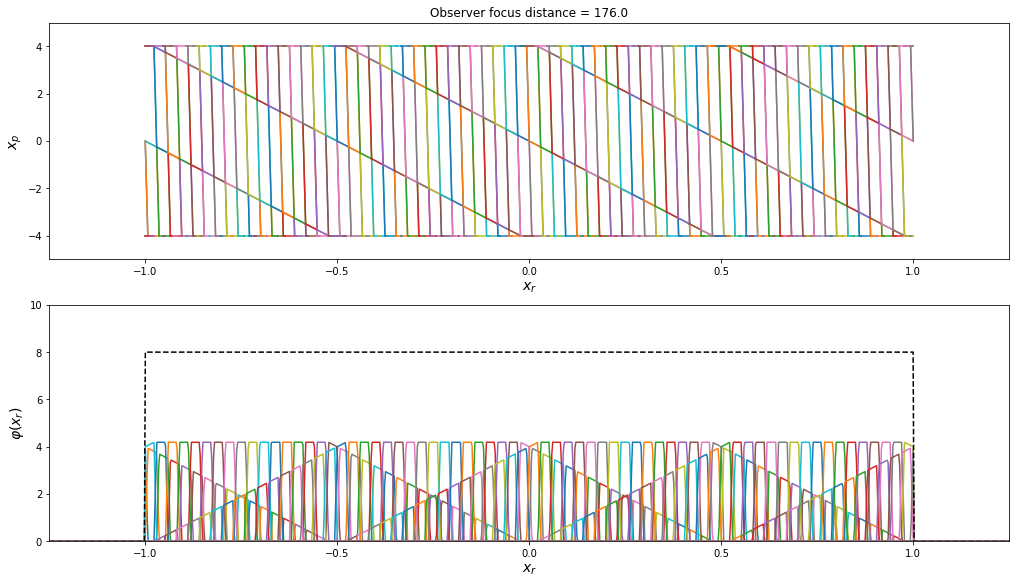

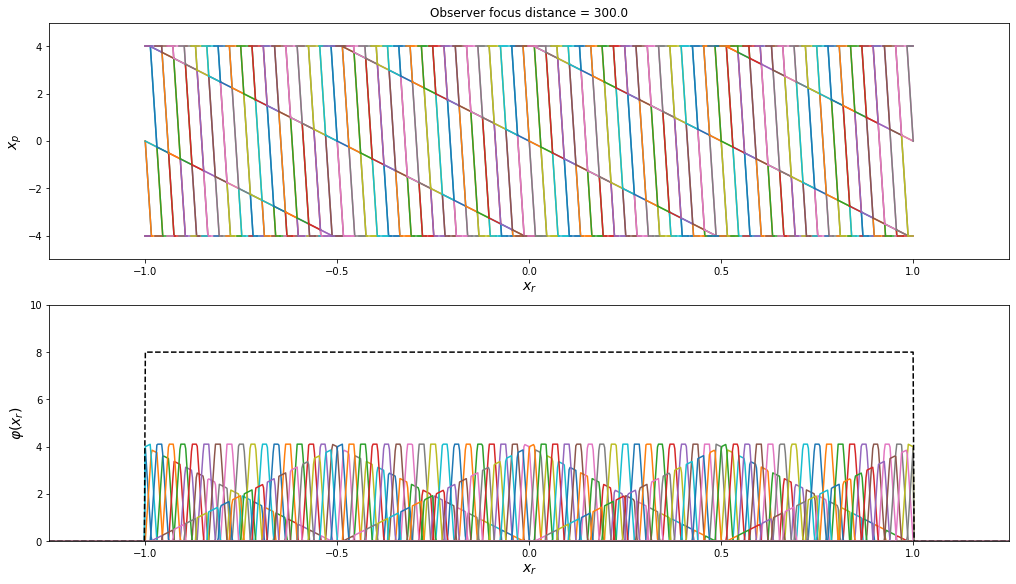

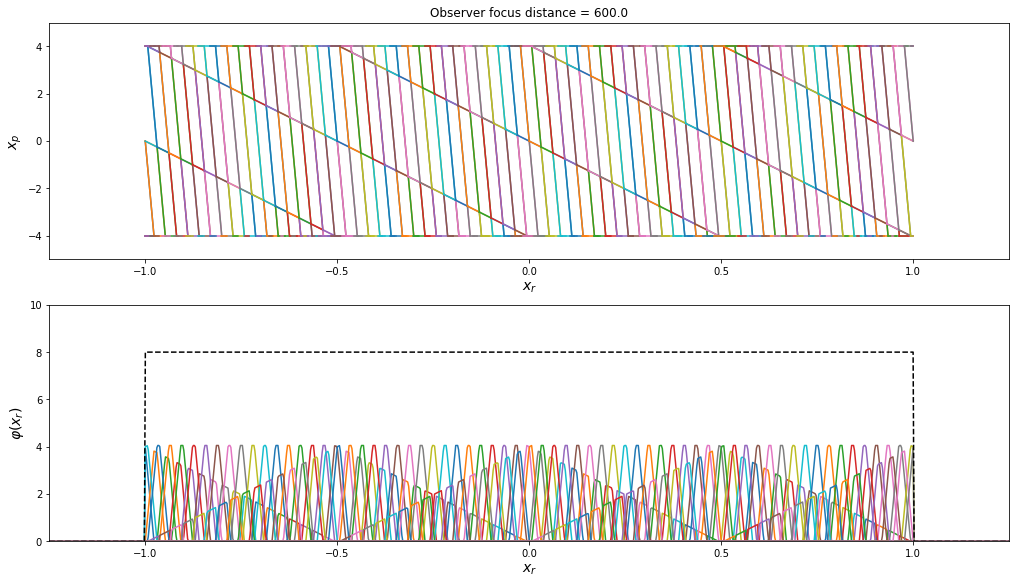

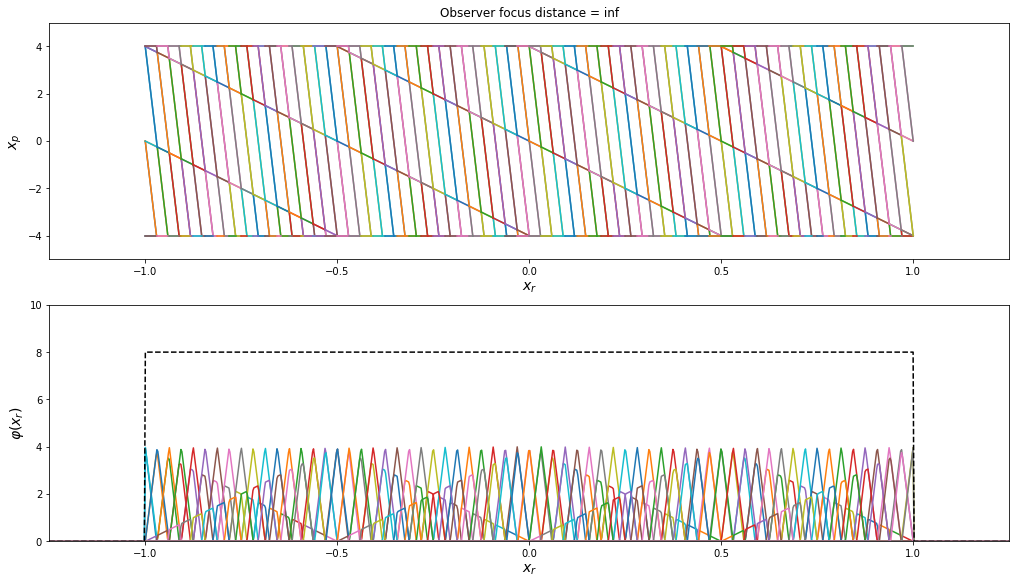

In [11]:
%%time
print('Plotting φ functions...')

def plot_phi(slope, intersect, interval, size_r, size_p, z_f):
    fig, axs = pyplot.subplots(2, constrained_layout=True, figsize=(14, 8))

    axs[0].set_title('Observer focus distance = {}'.format(z_f))

    axs[0].set_xlabel(r'$x_r$', fontsize=14)
    axs[0].set_ylabel(r'$x_p$', fontsize=14)
    axs[0].set_xlim(-size_r/1.6, size_r/1.6)
    axs[0].set_ylim(-size_p/1.6, size_p/1.6)

    axs[1].set_xlabel(r'$x_r$', fontsize=14)
    axs[1].set_ylabel(r'$\varphi(x_r)$', fontsize=14)
    axs[1].set_xlim(-size_r/1.6, size_r/1.6)
    axs[1].set_ylim(0, 2*size_p/1.6)

    pupil_position = (interval * slope + intersect) * [1, 1, 1, 1, 1, 1, -1, -1, -1, -1, -1, -1]
    x_r = np.linspace(-size_r/1.6, size_r/1.6, num=1000).reshape(-1, 1, 1)
    phi_value = evaluate_phi(x_r, slope, intersect, interval)

    for element_index in range(len(intersect)):
        color = axs[1].plot(np.squeeze(x_r), phi_value[:, element_index])[0].get_color()
        axs[0].plot(interval[:, element_index], pupil_position[:, element_index], color=color)

    axs[1].plot(np.squeeze(x_r), np.sum(phi_value, axis=-1), 'k--')

# For each focus distance...
for index_f, z_f in enumerate(focus_distances):
    plot_phi(phi_slopes[index_f], phi_intersects[index_f], phi_intervals[index_f], size_r, size_p, z_f)

In [ ]:
%%time
print('Computing "numerical" linear maps...')

reference_numerical_linear_map = sample_incidence_per_pixel.astype(np.float32) / np.maximum(sample_count_per_pixel, 1).reshape(n_f, n_r, 1, 1, 1)
naive_numerical_linear_map = sample_incidence_per_element.astype(np.float32) / np.maximum(sample_count_per_element, 1).reshape(n_ab, 1, 1, 1)

simulation_numerical_linear_map = np.zeros((n_f, n_r, n_ab), dtype=np.float32)
projection_numerical_linear_map = np.zeros((n_f, n_ab, n_p, n_chunk, chunk_s), dtype=np.float32)
autocorrelation_numerical_linear_map = np.zeros((n_f, n_ab, n_ab), dtype=np.float32)

coord_r_GPU = cp.array(sample_coord_r)
coord_a_GPU = cp.array(element_coord_a).reshape(-1, 1)
coord_b_GPU = cp.array(element_coord_b).reshape(-1, 1)

# For each retina pixel...
for index_r in trange(n_r):
    # For each focus distance...
    for index_f, z_f in enumerate(focus_distances):
        # Get incident light field samples and incident display elements.
        sample_indices = np.nonzero(sample_incidence_per_pixel[index_f, index_r])
        element_indices = np.nonzero(element_incidence_per_pixel[index_f, index_r])[0]
        # Compute phi for each sample incident on this pixel.
        phi_GPU = compute_phi_GPU(coord_r_GPU[index_f][sample_indices], coord_a_GPU[element_indices], coord_b_GPU[element_indices], pitch_a, pitch_b, size_p, z_a, z_b, z_f)
        # Simulation: Store the average phi value for each retina pixel.
        simulation_numerical_linear_map[index_f, index_r, element_indices] = cp.average(phi_GPU).get()
        # Projection: Store phi values divided by sample count per pixel.
        projection_numerical_linear_map[index_f, element_indices.reshape(-1, 1), sample_indices[0], sample_indices[1], sample_indices[2]] = phi_GPU.get() * pitch_r / sample_count_per_pixel[index_f, index_r]
        # Autocorrelation: For each pair of display elements, accumulate the average of the product of sampled phi values.
        autocorrelation_numerical_linear_map[index_f, element_indices.reshape(-1, 1), element_indices.reshape(1, -1)] += cp.average(phi_GPU[:, cp.newaxis, :] * phi_GPU[cp.newaxis, :, :], axis=2).get() * pitch_r

# Free GPU memory
del coord_r_GPU
del coord_a_GPU
del coord_b_GPU
del phi_GPU
mempool.free_all_blocks()



print('\nReference "numerical" Linear Map:')
array_stats(reference_numerical_linear_map)

print('\nNaive "numerical" Linear Map:')
array_stats(naive_numerical_linear_map)

print('\nSimulation "numerical" Linear Map:')
array_stats(simulation_numerical_linear_map)

print('\nProjection "numerical" Linear Map:')
array_stats(projection_numerical_linear_map)

print('\nAutocorrelation "numerical" Linear Map:')
array_stats(autocorrelation_numerical_linear_map)

In [ ]:
%%time
print('Computing "analytical" linear maps...')

simulation_analytical_linear_map = np.zeros((n_f, n_r, n_ab), dtype=np.float32)
autocorrelation_analytical_linear_map = np.zeros((n_f, n_ab, n_ab), dtype=np.float32)

print('\nSimulation "analytical" Linear Map:')
array_stats(simulation_analytical_linear_map)

print('\nAutocorrelation "analytical" Linear Map:')
array_stats(autocorrelation_analytical_linear_map)

In [ ]:
%%time
print('Computing "sampled" linear maps...')

simulation_sampled_linear_map = np.zeros((n_f, n_r, n_ab), dtype=np.float32)
autocorrelation_sampled_linear_map = np.zeros((n_f, n_ab, n_ab), dtype=np.float32)

coord_r_GPU = cp.array(lattice_r).reshape(-1, 1)
coord_a_GPU = cp.array(element_coord_a).reshape(1, -1)
coord_b_GPU = cp.array(element_coord_b).reshape(1, -1)

# For each focus distance...
for index_f, z_f in enumerate(focus_distances):
    # Compute central phi value for each display element at the center of each retina pixel.
    phi_GPU = compute_phi_GPU(coord_r_GPU, coord_a_GPU, coord_b_GPU, pitch_a, pitch_b, size_p, z_a, z_b, z_f)
    # Simulation: Store the central phi value for each display element at the center of each retina pixel.
    simulation_sampled_linear_map[index_f] = phi_GPU.get()
    # Autocorrelation: For each pair of display elements, accumulate the product of central phi values.
    autocorrelation_sampled_linear_map[index_f] = (phi_GPU.T @ phi_GPU).get() * pitch_r

# Free GPU memory
del coord_r_GPU
del coord_a_GPU
del coord_b_GPU
del phi_GPU
mempool.free_all_blocks()



print('\nSimulation "sampled" Linear Map:')
array_stats(simulation_sampled_linear_map)

print('\nAutocorrelation "sampled" Linear Map:')
array_stats(autocorrelation_sampled_linear_map)

In [ ]:
%%time
print('Plotting sampling space...')

def plot_sampling_space(lattice_p, lattice_r, element_coord_a, element_coord_b, lattice_s,
                        pitch_r, pitch_a, pitch_b, pitch_s, size_p, size_s, z_a, z_b, z_s, z_f):
    fig, ax = pyplot.subplots(1, constrained_layout=True, figsize=(14, 6))

    ax.set_xlabel(r'$x_s$', fontsize=14)
    ax.set_ylabel(r'$x_p$', fontsize=14)

    ax.set_xlim(lattice_s[0, 0] - pitch_s * 3, lattice_s[2, -1] + pitch_s * 3)
    ax.set_ylim(-size_p/1.6, size_p/1.6)

    ax.set_title('Observer focus distance = {}'.format(z_f))

    box_h = np.array([1, -1, -1,  1, 1]) / 2
    box_v = np.array([1,  1, -1, -1, 1]) / 2

    # Retina pixels.
    x_p = np.zeros_like(lattice_r) + box_v.reshape(-1, 1) * size_p
    x_r = lattice_r + box_h.reshape(-1, 1) * pitch_r
    ax.plot(pr_to_s(x_p, x_r, z_s, z_f), x_p, color='r')[0].set_label('Eye')

    # Display elements.
    x_a = element_coord_a + box_h.reshape(-1, 1) * pitch_a
    x_b = element_coord_b + box_v.reshape(-1, 1) * pitch_b
    ax.plot(ab_to_s(x_a, x_b, z_a, z_b, z_s), ab_to_p(x_a, x_b, z_a, z_b), color='g')[0].set_label('Display')

    # Light field samples.
    x_p, x_s = np.broadcast_arrays(lattice_p.reshape(-1, 1), lattice_s.reshape(1, -1))
    ax.vlines(lattice_s[0,  0] - pitch_s/2, -size_p/2, size_p/2, color='b', label='Sample Chunk')
    ax.vlines(lattice_s[:, -1] + pitch_s/2, -size_p/2, size_p/2, color='b')
    ax.hlines(np.array([-1, 1]) * size_p/2, -size_s/2, size_s/2, color='b')
    ax.scatter(x_s, x_p, s=1, color='b', label='Light Field Samples')

    # Legend
    ax.legend(loc='upper left', shadow=True)



for z_f in focus_distances:
    plot_sampling_space(lattice_p, lattice_r, element_coord_a, element_coord_b, lattice_s,
                        pitch_r, pitch_a, pitch_b, pitch_s, size_p, size_s, z_a, z_b, z_s, z_f)

In [ ]:
%%time
print('Plotting pixel assignment...')

def plot_pixel_assignment(lattice_p, lattice_r, element_coord_a, element_coord_b, lattice_s,
                          pitch_r, pitch_a, pitch_b, pitch_s, size_p, size_s, z_a, z_b, z_s, focus_distances,
                          element_incidence_per_pixel, pixel_assignment_per_group, index_group):
    fig, ax = pyplot.subplots(1, constrained_layout=True, figsize=(14, 6))

    ax.set_xlabel(r'$x_s$', fontsize=14)
    ax.set_ylabel(r'$x_p$', fontsize=14)

    ax.set_xlim(lattice_s[index_group, 0] - pitch_s * 20, lattice_s[index_group, -1] + pitch_s * 50)
    ax.set_ylim(-size_p/1.6, size_p/1.6)

    ax.set_title('Retina pixels assigned to light field group {}'.format(index_group))

    box_h = np.array([1, -1, -1,  1, 1]) / 2
    box_v = np.array([1,  1, -1, -1, 1]) / 2

    # Retina pixels.
    for k in range(3):
        ax.plot([], [])
    for index_f, z_f in enumerate(focus_distances):
        indices_r = np.nonzero(pixel_assignment_per_group[index_f, index_group])[0]
        x_p = np.zeros_like(indices_r) + box_v.reshape(-1, 1) * size_p
        x_r = lattice_r[indices_r] + box_h.reshape(-1, 1) * pitch_r
        color = ax.plot([], [])[0].get_color()
        ax.plot(pr_to_s(x_p, x_r, z_s, z_f), x_p, color=color)[0].set_label('Retina pixels {} to {} focused at {}'.format(indices_r[0], indices_r[-1], z_f))

    # Display elements.
    (4, 1024, 8882)
    indices_fr = np.nonzero(pixel_assignment_per_group[:, index_group])
    indices_ab = np.nonzero(np.any(element_incidence_per_pixel[indices_fr], axis=0))[0]
    x_a = element_coord_a[indices_ab] + box_h.reshape(-1, 1) * pitch_a
    x_b = element_coord_b[indices_ab] + box_v.reshape(-1, 1) * pitch_b
    ax.plot(ab_to_s(x_a, x_b, z_a, z_b, z_s), ab_to_p(x_a, x_b, z_a, z_b), color='g')[0].set_label('Display')

    # Light field samples.
    x_p, x_s = np.broadcast_arrays(lattice_p.reshape(-1, 1), lattice_s.reshape(1, -1))
    ax.vlines(lattice_s[0,  0] - pitch_s/2, -size_p/2, size_p/2, color='b', label='Sample Chunk')
    ax.vlines(lattice_s[:, -1] + pitch_s/2, -size_p/2, size_p/2, color='b')
    ax.hlines(np.array([-1, 1]) * size_p/2, -size_s/2, size_s/2, color='b')
    ax.scatter(x_s, x_p, s=1, color='b', label='Light Field Samples')

    # Legend
    ax.legend(loc='lower right', shadow=True)



for index_group in range(4):
    plot_pixel_assignment(lattice_p, lattice_r, element_coord_a, element_coord_b, lattice_s,
                          pitch_r, pitch_a, pitch_b, pitch_s, size_p, size_s, z_a, z_b, z_s, focus_distances,
                          element_incidence_per_pixel, pixel_assignment_per_group, index_group)

### Data Structures

#### Light Field

**Samples:** (46080, 46080)  
**Samples per Chunk:** (45, 45) × (1024, 1024)  
**Samples per Group:** (44, 44) × (2048, 2048)  
**Samples per Pixel:** (1024, 1024) × (64, 64)*  

#### Retina

**Pixels:** (1024, 1024)  
**Pixels per Group:** (44, 44) × (35, 35)*  

#### Display

**Elements:** (8882, 8882)  
**Elements per Group:** (44, 44) × (320, 320)*  
**Elements per Pixel:** (1024, 1024) × (54, 54)*  

### Reference

|                                |       **Dimensions**       |**Length**|**Data Type**| **Size** |
|:-------------------------------|:--------------------------:|:--------:|:-----------:|:--------:|
| **Input:** Samples             |             (46080, 46080) |    2×2³⁰ |    12 bytes |   24 GiB |
| **Ouput:** Pixels              | (1024, 1024)               |      2²⁰ |    12 bytes |   12 MiB |
| **Linear Map**                 | (1024, 1024, 46080, 46080) |    2×2⁵⁰ |     4 bytes |    8 PiB |
| **Separable Linear Map**       |       (1024, 46080)        |   45×2²⁰ |     4 bytes |  180 MiB |
|                                |       **Dimensions**       |**Length**|**Data Type**| **Size** |
| **Group Subproblem**           |         (44,    44)        |    2×2¹⁰ |  iterations |          |
| **Input:** Samples per Group   |              (2048,  2048) |    4×2²⁰ |    12 bytes |   48 MiB |
| **Ouput:** Pixels per Group    |   (35,   35)               |  1.2×2¹⁰ |    12 bytes | 14.4 KiB |
| **Linear Map**                 |   (35,   35,  2048,  2048) |  4.8×2³⁰ |     4 bytes | 19.2 GiB |
| **Separable Linear Map**       |         (35,  2048)        |   70×2¹⁰ |     4 bytes |  280 KiB |
|                                |       **Dimensions**       |**Length**|**Data Type**| **Size** |
| **Pixel Subproblem**           |       (1024,  1024)        |      2²⁰ |  iterations |          |
| **Input:** Samples per Pixel   |                (64,    64) |    4×2¹⁰ |    12 bytes |   64 KiB |
| **Ouput:** Pixels per Pixel    |    (1,    1)               |    1     |    12 bytes |   12 B   |
| **Linear Map**                 |    (1,    1,    64,    64) |    4×2¹⁰ |     4 bytes |   16 KiB |
| **Separable Linear Map**       |          (1,    64)        |   64     |     4 bytes |  256 B   |

### Projection

|                                |       **Dimensions**       |**Length**|**Data Type**| **Size** |
|:-------------------------------|:--------------------------:|:--------:|:-----------:|:--------:|
| **Input:** Samples             |             (46080, 46080) |    2×2³⁰ |    12 bytes |   24 GiB |
| **Ouput:** Elements            | (8882, 8882)               |   75×2²⁰ |    12 bytes |  900 MiB |
| **Linear Map**                 | (8882, 8882, 46080, 46080) |  150×2⁵⁰ |     4 bytes |  600 PiB |
| **Separable Linear Map**       |       (8882, 46080)        |  390×2²⁰ |     4 bytes |  1.5 GiB |
|                                |       **Dimensions**       |**Length**|**Data Type**| **Size** |
| **Group Subproblem**           |         (44,    44)        |    2×2¹⁰ |  iterations |          |
| **Input:** Samples per Group   |              (2048,  2048) |    4×2²⁰ |    12 bytes |   48 MiB |
| **Ouput:** Elements per Group  |  (320,  320)               |  100×2¹⁰ |    12 bytes |  1.2 MiB |
| **Linear Map**                 |  (320,  320,  2048,  2048) |  400×2³⁰ |     4 bytes |  1.6 TiB |
| **Separable Linear Map**       |        (320,  2048)        |  640×2¹⁰ |     4 bytes |  2.5 MiB |
|                                |       **Dimensions**       |**Length**|**Data Type**| **Size** |
| **Pixel Subproblem**           |       (1024,  1024)        |      2²⁰ |  iterations |          |
| **Input:** Samples per Pixel   |                (64,    64) |    4×2¹⁰ |    12 bytes |   64 KiB |
| **Ouput:** Elements per Pixel  |   (54,   54)               |  2.8×2¹⁰ |    12 bytes |   34 KiB |
| **Linear Map**                 |   (54,   54,    64,    64) |   11×2²⁰ |     4 bytes |   45 MiB |
| **Separable Linear Map**       |         (54,    64)        |  3.4×2¹⁰ |     4 bytes | 13.5 KiB |

### Autocorrelation

|                                |       **Dimensions**       |**Length**|**Data Type**| **Size** |
|:-------------------------------|:--------------------------:|:--------:|:-----------:|:--------:|
| **Input:** Elements            |              (8882,  8882) |   75×2²⁰ |    12 bytes |  900 MiB |
| **Ouput:** Elements            | (8882, 8882)               |   75×2²⁰ |    12 bytes |  900 MiB |
| **Linear Map**                 | (8882, 8882,  8882,  8882) |  5.5×2⁵⁰ |     4 bytes |   22 PiB |
| **Separable Linear Map**       |       (8882,  8882)        |   75×2²⁰ |     4 bytes |  300 MiB |
|                                |       **Dimensions**       |**Length**|**Data Type**| **Size** |
| **Group Subproblem**           |         (44,    44)        |    2×2¹⁰ |  iterations |          |
| **Input:** Elements per Group  |               (320,   320) |  100×2¹⁰ |    12 bytes |  1.2 MiB |
| **Ouput:** Elements per Group  |  (320,  320)               |  100×2¹⁰ |    12 bytes |  1.2 MiB |
| **Linear Map**                 |  (320,  320,   320,   320) |  9.8×2³⁰ |     4 bytes |   39 GiB |
| **Separable Linear Map**       |        (320,   320)        |  100×2¹⁰ |     4 bytes |  400 KiB |
|                                |       **Dimensions**       |**Length**|**Data Type**| **Size** |
| **Pixel Subproblem**           |       (1024,  1024)        |      2²⁰ |  iterations |          |
| **Input:** Elements per Pixel  |                (54,    54) |  2.8×2¹⁰ |    12 bytes |   34 KiB |
| **Ouput:** Elements per Pixel  |   (54,   54)               |  2.8×2¹⁰ |    12 bytes |   34 KiB |
| **Linear Map**                 |   (54,   54,    54,    54) |  8.1×2²⁰ |     4 bytes | 32.4 MiB |
| **Separable Linear Map**       |         (54,    54)        |  2.8×2¹⁰ |     4 bytes | 11.4 KiB |

In [ ]:
%%time
print('Processing the light field samples...')

reference_images = np.zeros((n_f, n_r, n_r, 3), dtype=np.float32)
element_naive = np.zeros((n_ab, n_ab, 3), dtype=np.float32)
element_projected = np.zeros((n_f, n_ab, n_ab, 3), dtype=np.float32)

light_field = zarr.open('data/sponza_sampled.zarr', mode='r')

with tqdm(total=n_group * n_group * n_f) as pbar:
    # Load initial values from sampled light field.
    sample_values = np.empty((n_p, chunk_group, chunk_s, n_p, n_chunk, chunk_s, 3), dtype=np.float32)
    sample_values[:, 1:, :] = light_field[:, :chunk_group-1, :]

    for idx_group in range(n_group):
        slice_x = slice(idx_group, idx_group + chunk_group)
        
        # Load more values from sampled light field.
        sample_values[:, :-1, :] = sample_values[:, 1:, :]
        sample_values[:, -1, :] = light_field[:, idx_group+chunk_group-1, :]

        # Load horizontal linear maps into the GPU for this column of groups.
        reference_x_GPU = cp.array(reference_numerical_linear_map[:, :, :, slice_x, :].reshape(n_f, n_r, n_p * chunk_group * chunk_s))
        naive_x_GPU = cp.array(naive_numerical_linear_map[:, :, slice_x, :].reshape(n_ab, n_p * chunk_group * chunk_s))
        projection_x_GPU = cp.array(projection_numerical_linear_map[:, :, :, slice_x, :].reshape(n_f, n_ab, n_p * chunk_group * chunk_s))

        for idy_group in range(n_group):
            slice_y = slice(idy_group, idy_group + chunk_group)

            # Load sample values into the GPU for this group.
            sample_values_GPU = cp.array(sample_values[:, :, :, :, slice_y, :].reshape(n_p * chunk_group * chunk_s, n_p * chunk_group * chunk_s, 3))

            # Load vertical linear maps into the GPU for this group.
            reference_y_GPU = cp.array(reference_numerical_linear_map[:, :, :, slice_y, :].reshape(n_f, n_r, n_p * chunk_group * chunk_s))
            naive_y_GPU = cp.array(naive_numerical_linear_map[:, :, slice_y, :].reshape(n_ab, n_p * chunk_group * chunk_s))
            projection_y_GPU = cp.array(projection_numerical_linear_map[:, :, :, slice_y, :].reshape(n_f, n_ab, n_p * chunk_group * chunk_s))

            # Display elements assigned to this group.
            idx_element = element_indices_per_group[idx_group]
            idy_element = element_indices_per_group[idy_group]
            # Compute naive coefficients.
            element_naive[np.ix_(idx_element, idy_element)] = cp.tensordot(naive_x_GPU[idx_element], cp.tensordot(naive_y_GPU[idy_element], sample_values_GPU, axes=(1, 1)), axes=(1, 1)).get()

            # For each focus distance...
            for index_f, z_f in enumerate(focus_distances):
                # Retina pixels assigned to this group.
                idx_pixel = pixel_indices_per_group[index_f][idx_group]
                idy_pixel = pixel_indices_per_group[index_f][idy_group]
                # Compute reference image.
                reference_images[index_f][np.ix_(idx_pixel, idy_pixel)] = cp.tensordot(reference_x_GPU[index_f, idx_pixel], cp.tensordot(reference_y_GPU[index_f, idy_pixel], sample_values_GPU, axes=(1, 1)), axes=(1, 1)).get()
                # Display elements incident on the assigned retina pixels.
                idx_element = np.nonzero(np.any(element_incidence_per_pixel[index_f, idx_pixel], axis=0))[0]
                idy_element = np.nonzero(np.any(element_incidence_per_pixel[index_f, idy_pixel], axis=0))[0]
                # Compute projection coefficients.
                element_projected[index_f][np.ix_(idx_element, idy_element)] = cp.tensordot(projection_x_GPU[index_f, idx_element], cp.tensordot(projection_y_GPU[index_f, idy_element], sample_values_GPU, axes=(1, 1)), axes=(1, 1)).get()
                # Update progress bar.
                pbar.update()

            # Free GPU memory
            del sample_values_GPU
            del reference_y_GPU
            del naive_y_GPU
            del projection_y_GPU
            mempool.free_all_blocks()

        # Free GPU memory
        del reference_x_GPU
        del naive_x_GPU
        del projection_x_GPU
        mempool.free_all_blocks()

In [ ]:
# Naive and projection display element coefficients.
print(' \n \nNaive coefficients:')
array_stats(element_naive)
display_image(element_naive[::10, ::10] / np.amax(element_naive))
for index_f, z_f in enumerate(focus_distances):
    print(' \n \nProjected coefficients for focus distance at {}'.format(z_f))
    array_stats(element_projected[index_f])
    display_image(element_projected[index_f, ::10, ::10] / np.amax(element_projected[index_f]))

In [ ]:
%%time
print('Computing optimal "sampled" coefficients...')

rng = cp.random.default_rng()

element_optimal = np.zeros((n_f, n_ab, n_ab, 3), dtype=np.float32)

with tqdm(total=n_f * 10) as pbar:
    # For each focus distance...
    for index_f, z_f in enumerate(focus_distances):
        # Load the autocorrelation linear map into the GPU.
        autocorrelation_GPU = cp.array(autocorrelation_sampled_linear_map[index_f])

        # Load the projection coefficients into the GPU.
        projected_GPU = cp.array(element_projected[index_f])

        # Initialize display elements with random coefficients.
        element_GPU = 1.0 - rng.random((n_ab, n_ab, 3), dtype=cp.float32)

        # For each multiplicative rule iteration...
        for iteration in range(10):
            # Apply the autocorrelation linear map on current coefficients.
            temp_GPU = cp.tensordot(autocorrelation_GPU, cp.tensordot(autocorrelation_GPU, element_GPU, axes=(1, 1)), axes=(1, 1))
            # Divide the projected coefficients by the autocorrelated coefficients.
            temp_GPU = cp.add(temp_GPU, cp.finfo(cp.float32).eps, out=temp_GPU)
            temp_GPU = cp.divide(projected_GPU, temp_GPU, out=temp_GPU)
            # Update current coefficients with the multiplicative rule.
            element_GPU = cp.multiply(element_GPU, temp_GPU, out=element_GPU)
            # Update progress bar.
            pbar.update()

        # Store coefficients after the last iteration.
        element_optimal[index_f] = element_GPU.get()

        # Free GPU memory
        del autocorrelation_GPU
        del projected_GPU
        del element_GPU
        del temp_GPU
        mempool.free_all_blocks()

In [ ]:
# Optimal display element coefficients.
for index_f, z_f in enumerate(focus_distances):
    print(' \n \nOptimal "sampled" coefficients for focus distance at {}'.format(z_f))
    array_stats(element_optimal[index_f])
    display_image(element_optimal[index_f, ::10, ::10] / np.amax(element_optimal[index_f]))

In [ ]:
%%time
print('Computing "sampled" retina images...')

with tqdm(total=n_f) as pbar:
    # For each focus distance...
    for index_f, z_f in enumerate(focus_distances):
        # Load the simulation linear map into the GPU.
        simulation_GPU = cp.array(simulation_sampled_linear_map[index_f])
        
        print(' \n \nReference with observer focus distance at {}'.format(z_f))
        array_stats(reference_images[index_f])
        display_image(reference_images[index_f])

        print(' \n \nNaive with observer focus distance at {}'.format(z_f))
        element_GPU = cp.array(element_naive)
        retina_image = cp.tensordot(simulation_GPU, cp.tensordot(simulation_GPU, element_GPU, axes=(1, 1)), axes=(1, 1)).get()
        array_stats(retina_image)
        display_image(retina_image)

        print(' \n \nProjected for {} with observer focus distance at {}'.format(z_f, z_f))
        element_GPU = cp.array(element_projected[index_f])
        retina_image = cp.tensordot(simulation_GPU, cp.tensordot(simulation_GPU, element_GPU, axes=(1, 1)), axes=(1, 1)).get()
        array_stats(retina_image)
        display_image(retina_image / np.amax(retina_image))

        print(' \n \nOptimal for {} with observer focus distance at {}'.format(z_f, z_f))
        element_GPU = cp.array(element_optimal[index_f])
        retina_image = cp.tensordot(simulation_GPU, cp.tensordot(simulation_GPU, element_GPU, axes=(1, 1)), axes=(1, 1)).get()
        array_stats(retina_image)
        display_image(retina_image / np.amax(retina_image))

        # Update progress bar.
        pbar.update()

        # Free GPU memory
        del simulation_GPU
        del element_GPU
        mempool.free_all_blocks()

In [ ]:
%%time
print('Computing optimal "numerical" coefficients...')

rng = cp.random.default_rng()

element_optimal = np.zeros((n_f, n_ab, n_ab, 3), dtype=np.float32)

with tqdm(total=n_f * 10) as pbar:
    # For each focus distance...
    for index_f, z_f in enumerate(focus_distances):
        # Load the autocorrelation linear map into the GPU.
        autocorrelation_GPU = cp.array(autocorrelation_numerical_linear_map[index_f])

        # Load the projection coefficients into the GPU.
        projected_GPU = cp.array(element_projected[index_f])

        # Initialize display elements with random coefficients.
        element_GPU = 1.0 - rng.random((n_ab, n_ab, 3), dtype=cp.float32)

        # For each multiplicative rule iteration...
        for iteration in range(10):
            # Apply the autocorrelation linear map on current coefficients.
            temp_GPU = cp.tensordot(autocorrelation_GPU, cp.tensordot(autocorrelation_GPU, element_GPU, axes=(1, 1)), axes=(1, 1))
            # Divide the projected coefficients by the autocorrelated coefficients.
            temp_GPU = cp.add(temp_GPU, cp.finfo(cp.float32).eps, out=temp_GPU)
            temp_GPU = cp.divide(projected_GPU, temp_GPU, out=temp_GPU)
            # Update current coefficients with the multiplicative rule.
            element_GPU = cp.multiply(element_GPU, temp_GPU, out=element_GPU)
            # Update progress bar.
            pbar.update()

        # Store coefficients after the last iteration.
        element_optimal[index_f] = element_GPU.get()

        # Free GPU memory
        del autocorrelation_GPU
        del projected_GPU
        del element_GPU
        del temp_GPU
        mempool.free_all_blocks()

In [ ]:
# Optimal display element coefficients.
for index_f, z_f in enumerate(focus_distances):
    print(' \n \nOptimal "numerical" coefficients for focus distance at {}'.format(z_f))
    array_stats(element_optimal[index_f])
    display_image(element_optimal[index_f, ::10, ::10] / np.amax(element_optimal[index_f]))

In [ ]:
%%time
print('Computing "numerical" retina images...')

with tqdm(total=n_f) as pbar:
    # For each focus distance...
    for index_f, z_f in enumerate(focus_distances):
        # Load the simulation linear map into the GPU.
        simulation_GPU = cp.array(simulation_numerical_linear_map[index_f])
        
        print(' \n \nReference with observer focus distance at {}'.format(z_f))
        array_stats(reference_images[index_f])
        display_image(reference_images[index_f])

        print(' \n \nNaive with observer focus distance at {}'.format(z_f))
        element_GPU = cp.array(element_naive)
        retina_image = cp.tensordot(simulation_GPU, cp.tensordot(simulation_GPU, element_GPU, axes=(1, 1)), axes=(1, 1)).get()
        array_stats(retina_image)
        display_image(retina_image)

        print(' \n \nProjected for {} with observer focus distance at {}'.format(z_f, z_f))
        element_GPU = cp.array(element_projected[index_f])
        retina_image = cp.tensordot(simulation_GPU, cp.tensordot(simulation_GPU, element_GPU, axes=(1, 1)), axes=(1, 1)).get()
        array_stats(retina_image)
        display_image(retina_image / np.amax(retina_image))

        print(' \n \nOptimal for {} with observer focus distance at {}'.format(z_f, z_f))
        element_GPU = cp.array(element_optimal[index_f])
        retina_image = cp.tensordot(simulation_GPU, cp.tensordot(simulation_GPU, element_GPU, axes=(1, 1)), axes=(1, 1)).get()
        array_stats(retina_image)
        display_image(retina_image / np.amax(retina_image))

        # Update progress bar.
        pbar.update()

        # Free GPU memory
        del simulation_GPU
        del element_GPU
        mempool.free_all_blocks()

In [ ]:
%%time
print('Computing optimal "analytical" coefficients...')

rng = cp.random.default_rng()

element_optimal = np.zeros((n_f, n_ab, n_ab, 3), dtype=np.float32)

with tqdm(total=n_f * 10) as pbar:
    # For each focus distance...
    for index_f, z_f in enumerate(focus_distances):
        # Load the autocorrelation linear map into the GPU.
        autocorrelation_GPU = cp.array(autocorrelation_analytical_linear_map[index_f])

        # Load the projection coefficients into the GPU.
        projected_GPU = cp.array(element_projected[index_f])

        # Initialize display elements with random coefficients.
        element_GPU = 1.0 - rng.random((n_ab, n_ab, 3), dtype=cp.float32)

        # For each multiplicative rule iteration...
        for iteration in range(10):
            # Apply the autocorrelation linear map on current coefficients.
            temp_GPU = cp.tensordot(autocorrelation_GPU, cp.tensordot(autocorrelation_GPU, element_GPU, axes=(1, 1)), axes=(1, 1))
            # Divide the projected coefficients by the autocorrelated coefficients.
            temp_GPU = cp.add(temp_GPU, cp.finfo(cp.float32).eps, out=temp_GPU)
            temp_GPU = cp.divide(projected_GPU, temp_GPU, out=temp_GPU)
            # Update current coefficients with the multiplicative rule.
            element_GPU = cp.multiply(element_GPU, temp_GPU, out=element_GPU)
            # Update progress bar.
            pbar.update()

        # Store coefficients after the last iteration.
        element_optimal[index_f] = element_GPU.get()

        # Free GPU memory
        del autocorrelation_GPU
        del projected_GPU
        del element_GPU
        del temp_GPU
        mempool.free_all_blocks()

In [ ]:
# Optimal display element coefficients.
for index_f, z_f in enumerate(focus_distances):
    print(' \n \nOptimal "numerical" coefficients for focus distance at {}'.format(z_f))
    array_stats(element_optimal[index_f])
    display_image(element_optimal[index_f, ::10, ::10] / np.amax(element_optimal[index_f]))

In [ ]:
%%time
print('Computing "analytical" retina images...')

with tqdm(total=n_f) as pbar:
    # For each focus distance...
    for index_f, z_f in enumerate(focus_distances):
        # Load the simulation linear map into the GPU.
        simulation_GPU = cp.array(simulation_analytical_linear_map[index_f])
        
        print(' \n \nReference with observer focus distance at {}'.format(z_f))
        array_stats(reference_images[index_f])
        display_image(reference_images[index_f])

        print(' \n \nNaive with observer focus distance at {}'.format(z_f))
        element_GPU = cp.array(element_naive)
        retina_image = cp.tensordot(simulation_GPU, cp.tensordot(simulation_GPU, element_GPU, axes=(1, 1)), axes=(1, 1)).get()
        array_stats(retina_image)
        display_image(retina_image)

        print(' \n \nProjected for {} with observer focus distance at {}'.format(z_f, z_f))
        element_GPU = cp.array(element_projected[index_f])
        retina_image = cp.tensordot(simulation_GPU, cp.tensordot(simulation_GPU, element_GPU, axes=(1, 1)), axes=(1, 1)).get()
        array_stats(retina_image)
        display_image(retina_image / np.amax(retina_image))

        print(' \n \nOptimal for {} with observer focus distance at {}'.format(z_f, z_f))
        element_GPU = cp.array(element_optimal[index_f])
        retina_image = cp.tensordot(simulation_GPU, cp.tensordot(simulation_GPU, element_GPU, axes=(1, 1)), axes=(1, 1)).get()
        array_stats(retina_image)
        display_image(retina_image / np.amax(retina_image))

        # Update progress bar.
        pbar.update()

        # Free GPU memory
        del simulation_GPU
        del element_GPU
        mempool.free_all_blocks()